In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("darkgrid")

Скачиваем нужные данные:

In [2]:
tweets = pd.read_csv('https://raw.githubusercontent.com/evlko/CS-224W/main/Data/Twitter/tweets_covid19_GL.csv')

# Preprocessing 

In [ ]:
import nltk
import re
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('movie_reviews', quiet=True)

Совершенно стандратный препроцессинг для текста 

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [6]:
def remove_words_with_sym(text, symbol='#'):
  return re.sub(r'{}[^\s]*'.format(symbol), '', text)

assert remove_words_with_sym('Hello, it\'s a me, Mario!, #Top') == 'Hello, it\'s a me, Mario!, '
assert remove_words_with_sym('Hello, it\'s a me, @Mario!', '@') == 'Hello, it\'s a me, '

In [7]:
def preprocess(text, special_symbols=['#', '@', 'http', 'pic twitter c']):
    for special_symbol in special_symbols:
      text = remove_words_with_sym(text, special_symbol)
    text = re.sub(r'[^\w\s]', '', text).replace('_', '')
    text = text.lower()
    text = [lemmatizer.lemmatize(word) for word in word_tokenize(text) if lemmatizer.lemmatize(word) not in stop_words] 
    text = ' '.join(text)

    return text

assert preprocess('Hello, it\'s a me, Mario!') == 'hello mario'

Обрабатываем необходимые данные:

In [8]:
tweets['text'] = tweets['text'].apply(preprocess)

# Topic Modeling

In [9]:
import gensim
from gensim import corpora

Для того, чтобы приступить к моделанированию тем, необходимо явно разбить весь наш набор данных на документы, которые состят из слов. Более того, будем исходить из двух важных предположений:
1. Документ содержит несколько тем
2. Тема содержит несколько слов

Таким образом, мы моделируем 2 распределения.

* Токены — слова 
* Словарь — частотность токенов
* Корпус — набор документов с заменнеными словами на (индекс; частотность)

In [10]:
tweets['tokenized_sents'] = tweets.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
docs = tweets['tokenized_sents'].tolist()
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

## LDA (Latent Dirichlet Allocation)

In [11]:
from gensim.models import LdaMulticore, CoherenceModel, LdaModel

Для моделирования тем будем использовать библиотеку `gensim` и модель `LDA` с метрикой `c_v`. Идея довольно простая, для каждого документа $d$ (из множества $D$) мы предсказываем вектор Θ-вероятностей отнесения к топику $k$ (из множества $K$)
* **LDA** - алгоритм, идея которого основана предположении, что каждое слово в каждом документа принадлежит какому-то топику, а каждый топик имеет своё распределение слов. Также есть предположение (как в NB), что слова независимые, таким образом, мы максимизируем:
$\hat{β_{1:K}}, \hat{\theta_{1:D}} = argmax_{β_{1:K}, \theta_{1:D}} P (\{w_{nd}\}^{N,D}_{n=1,d=1}|\beta_{1:K},\theta_{1:D})$
Таким образом, $p(w|z) = \beta_z$
* **Coherence** - некоторая когерентность, которую мы определяем сами. Метрика оценивает, насколько хорошо тема "поддерживается" набором текстов.
* **c_v** - один из методов, который может быть использован в алгоритме.
** Сегментация: Используется метод *S-one-se*t, то есть мера подтверждения будет вычисляться над парами слова и множества W.
** Вычисление вероятности: Используется метод *Psw(110)*. Вероятности рассчитываются по скользящему окну размером 110, которое перемещается по текстам.
** Мера подтверждения: Используется косвенная мера подтверждения. Слова элементов каждой пары сравниваются со всеми остальными словами *W* с помощью меры *m_nlr*. Окончательным результатом является косинусное сходство между двумя векторами мер.
** Агрегация: Итоговая когерентность - это среднее арифметическое мер подтверждения.

Алгоритм:

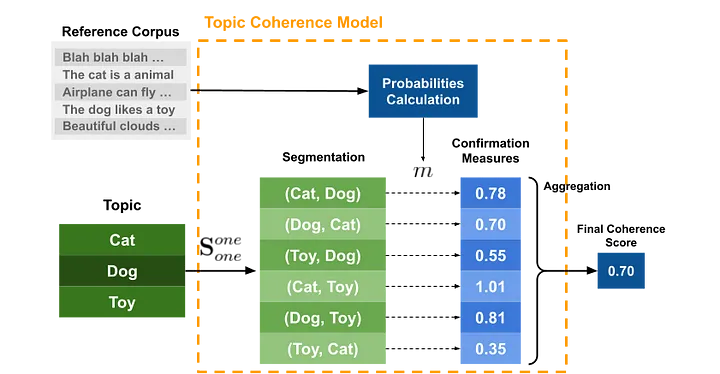

Другие техники (мы используем c_v):

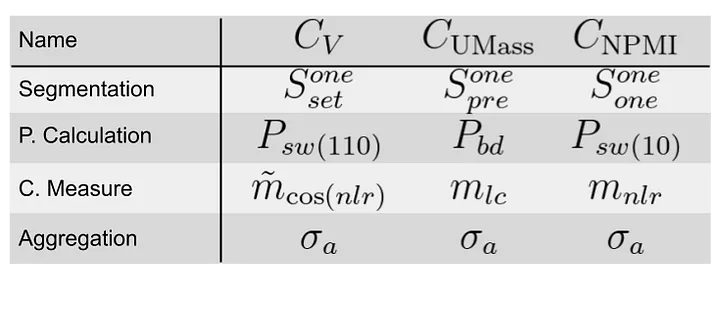

Попробуем взять разлное число топиков (от 1 до 10) и посмотрим на результаты

In [12]:
coherence_values = []
num_topics = list(range(1, 11, 1))

for i in tqdm(num_topics):
  model = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary)
  coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
  coherence_values.append(coherencemodel.get_coherence())

100%|██████████| 10/10 [09:41<00:00, 58.15s/it]


In [13]:
data = {
    'topics': num_topics,
    'coherence': coherence_values,
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


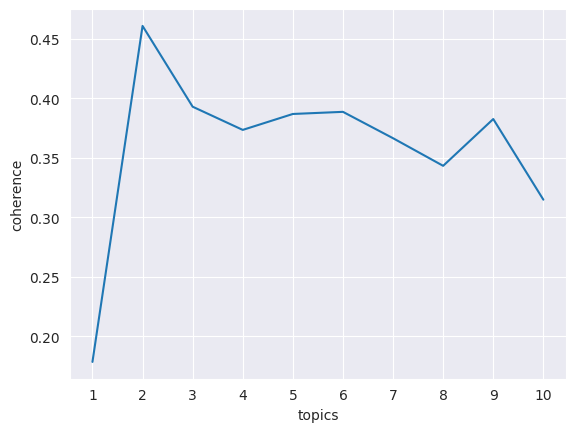

In [22]:
g = sns.lineplot(data=data, x='topics', y='coherence')
g.set_xticks(num_topics)

Как видно, лучше всего подходит 2 топика.

Пересобираем модель

In [29]:
best_cv, best_topics = 0, 0
for t, c in zip(num_topics, coherence_values):
  if c > best_cv:
    best_cv = c
    best_topics = t

model = LdaModel(corpus=corpus, num_topics=best_topics, id2word=dictionary)
coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Визуализация

Визуализируем (инетрактивно!) полученные результаты с помощью `pyLDAvis`

In [ ]:
!pip install pyLDAvis

Необходимо установить старый `pandas`, так как у нового нет совместимости с `pyLDAvis`

In [ ]:
!pip install "pandas<2.0.0"

In [16]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [30]:
vis = gensimvis.prepare(model, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.215411  0.0       1        1  62.703263
0     -0.215411  0.0       2        1  37.296737, topic_info=        Term          Freq         Total Category  logprob  loglift
75      case  22626.000000  22626.000000  Default  30.0000  30.0000
277      new  15514.000000  15514.000000  Default  29.0000  29.0000
42     death  12192.000000  12192.000000  Default  28.0000  28.0000
238    total   5956.000000   5956.000000  Default  27.0000  27.0000
232      day   5760.000000   5760.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
285     week   2655.275419   2930.069191   Topic2  -5.3994   0.8878
77   covid19   6773.380264   9688.389928   Topic2  -4.4630   0.6283
371    state   2777.836295   3526.853866   Topic2  -5.3543   0.7475
29        ha   3499.745524  11862.722004   Topic2  -5.1233  -0.2344
120   people   2311.596177   9488.409535   Topic2  -5.5380  -0.4259

[160 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
436       1  0.009085          1
436       2  0.990601          1
204       1  0.066777          2
204       2  0.933099          2
150       1  0.000248       2020
...     ...       ...        ...
52        2  0.000864       work
1228      1  0.001185  worldwide
1228      2  0.998884  worldwide
9         1  0.993613      would
9         2  0.006437      would

[253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

Топик 1:

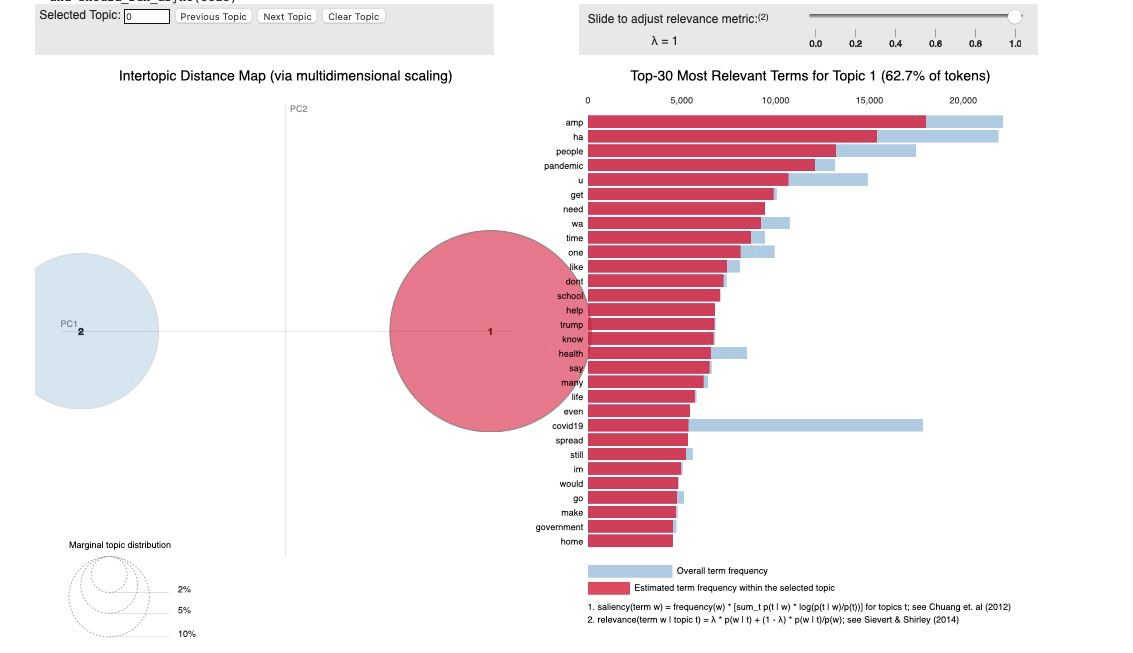

Топик 2:

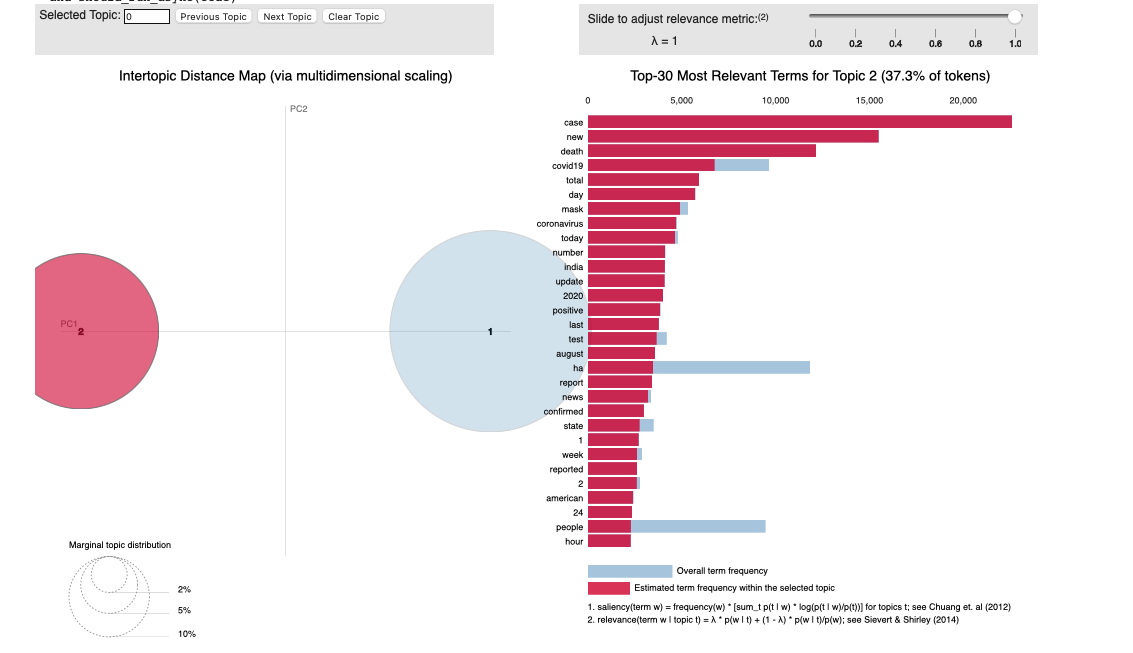

По словам можно определить тематику топиков:
1. Больше про политику и социальные взаимодействия;
2. Статистика, факты, новости (кейсы, цифры, гео).